In [3]:
import numpy as np
import pandas as pd
import re

tr = pd.read_parquet("cheating/x_train.pa")
tst = pd.read_parquet("cheating/x_test.pa")

In [7]:
def preprocess_for_lgbm(df):
    df = df.copy()

    object_cols = ['mcc_code__lambda_0_', 'time_of_day__lambda_0_']
    for col in object_cols:
        df[col] = df[col].astype('category')

    return df


def clean_feature_name(name):
    """Заменяет все спецсимволы на подчеркивания."""
    return re.sub(r'[^a-zA-Z0-9_]', '_', str(name))


tr.columns = [clean_feature_name(col) for col in tr.columns]
tst.columns = [clean_feature_name(col) for col in tst.columns]

tr = preprocess_for_lgbm(tr)
tst = preprocess_for_lgbm(tst)

In [8]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd


lgb_X = tr.drop(columns=["target"])
lgb_y = tr["target"]
lgb_X_test = tst

lgb_categorical_features = tr.select_dtypes(include=['category', 'object']).columns.tolist()

lgb_X_train, lgb_X_val, lgb_y_train, lgb_y_val = train_test_split(
    lgb_X, lgb_y, test_size=0.37, random_state=42, stratify=lgb_y
)

lgb_train_data = lgb.Dataset(lgb_X_train, label=lgb_y_train, categorical_feature=lgb_categorical_features, free_raw_data=False)
lgb_val_data = lgb.Dataset(lgb_X_val, label=lgb_y_val, categorical_feature=lgb_categorical_features, free_raw_data=False)

lgb_params = {
    "objective": "multiclass",
    "num_class": 8,
    "metric": "None",
    "learning_rate": 0.05,
    "num_leaves": 64,
    "max_depth": 7,
    "verbosity": -1,
    "seed": 42,
}

weights_by_class = {
    0: 1.00,
    1: 0.72,
    2: 0.52,
    3: 0.37,
    4: 0.27,
    5: 0.19,
    6: 0.14,
    7: 0.00,
}

def compute_wmae(y_true, y_pred):
    """WMAE без нормировки: просто среднее взвешенное абсолютное отклонение."""
    weights = np.vectorize(weights_by_class.get)(y_true)
    return np.mean(weights * np.abs(y_true - y_pred))


def feval_wmae(preds, train_data):
    """LightGBM-compatible WMAE без нормировки."""
    y_true = train_data.get_label()
    y_pred = preds.reshape(-1, 8).argmax(axis=1)
    weights = np.vectorize(weights_by_class.get)(y_true)
    error = np.mean(weights * np.abs(y_true - y_pred))
    return "wmae", error, False



model = lgb.train(
    lgb_params,
    lgb_train_data,
    valid_sets=[lgb_train_data, lgb_val_data],
    feval=feval_wmae,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100),
    ],
)


lgb_val_preds_proba = model.predict(lgb_X_val)
lgb_val_preds_class = lgb_val_preds_proba.argmax(axis=1)
lgb_y_val_np = lgb_y_val.to_numpy()

wmae_score = compute_wmae(lgb_y_val_np, lgb_val_preds_class)
print(f"\n📊 Validation WMAE: {wmae_score:.5f}")

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	training's wmae: 0.45633	valid_1's wmae: 0.537361

📊 Validation WMAE: 0.53736


In [21]:
#thresholds = { 0: 0.23, 1: 0.25, 2: 0.14, 3: 0.11, 4: 0.11, 5: 0.09, 6: 0.075, 7: 0.04}
thresholds = { 
    0: 0.2245, 
    1: 0.2245, 
    2: 0.1020, 
    3: 0.1429, 
    4: 0.05, 
    5: 0.05, 
    6: 0.05, 
    7: 0.05
}


def predict_with_thresholds(probas, thresholds):
    preds = []
    for row in probas:
        above_threshold = [i for i, p in enumerate(row) if p >= thresholds[i]]
        if not above_threshold:
            preds.append(np.argmax(row))  # fallback
        else:
            # можно выбрать тот, где p * weight максимальны
            preds.append(max(above_threshold, key=lambda i: row[i] * weights_by_class[i]))
    return np.array(preds)

lgb_val_preds_custom = predict_with_thresholds(lgb_val_preds_proba, thresholds)

wmae_score = compute_wmae(lgb_y_val_np, lgb_val_preds_custom)
print(f"\n📊 Validation WMAE: {wmae_score:.5f}")


📊 Validation WMAE: 0.52883


In [23]:
test_preds = model.predict(lgb_X_test)
test_preds_labels = predict_with_thresholds(test_preds, thresholds)

submission = pd.DataFrame({
    "client_num": tst["client_num"],
    "target": test_preds_labels
})

submission.to_csv("full_ch_sub.csv", index=False)

In [10]:
def optimize_thresholds_grid(probas, y_true, initial_thresholds, weights_by_class, compute_wmae_fn, steps=20):
    thresholds = initial_thresholds.copy()
    for class_idx in range(len(thresholds)):
        best_threshold = thresholds[class_idx]
        best_score = float('inf')
        
        # Генерируем шаги между 0 и 1
        search_space = np.linspace(0, 1, steps)
        for t in search_space:
            temp_thresholds = thresholds.copy()
            temp_thresholds[class_idx] = t
            preds = predict_with_thresholds(probas, temp_thresholds)
            score = compute_wmae_fn(y_true, preds)
            if score < best_score:
                best_score = score
                best_threshold = t
        thresholds[class_idx] = best_threshold
        print(f"✅ Optimized threshold for class {class_idx}: {best_threshold:.4f}, WMAE: {best_score:.5f}")
    return thresholds


lgb_train_preds_proba = model.predict(lgb_X)  # shape: (N, num_classes)

# 3. Подбор порогов на всём трейне
initial_thresholds = np.array([0.20, 0.25, 0.14, 0.11, 0.11, 0.09, 0.075, 0.04])

best_thresholds = optimize_thresholds_grid(
    lgb_train_preds_proba,
    lgb_y.to_numpy(),  # обязательно в numpy
    initial_thresholds,
    weights_by_class,
    compute_wmae_fn=compute_wmae,
    steps=50
)

# 4. Финальный WMAE на трейне
lgb_train_preds_custom = predict_with_thresholds(lgb_train_preds_proba, best_thresholds)
wmae_score = compute_wmae(lgb_y.to_numpy(), lgb_train_preds_custom)
print(f"\n📊 Final WMAE on full train set after threshold optimization: {wmae_score:.5f}")


✅ Optimized threshold for class 0: 0.2245, WMAE: 0.49488
✅ Optimized threshold for class 1: 0.2245, WMAE: 0.49230
✅ Optimized threshold for class 2: 0.1020, WMAE: 0.48813
✅ Optimized threshold for class 3: 0.1429, WMAE: 0.48804
✅ Optimized threshold for class 4: 0.1020, WMAE: 0.48804
✅ Optimized threshold for class 5: 0.1837, WMAE: 0.48804
✅ Optimized threshold for class 6: 0.2653, WMAE: 0.48800
✅ Optimized threshold for class 7: 0.0204, WMAE: 0.48800

📊 Final WMAE on full train set after threshold optimization: 0.48800


c:\Users\Admin\anaconda3\Lib\site-packages\shap\plots\_beeswarm.py:1153: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  pl.tight_layout()


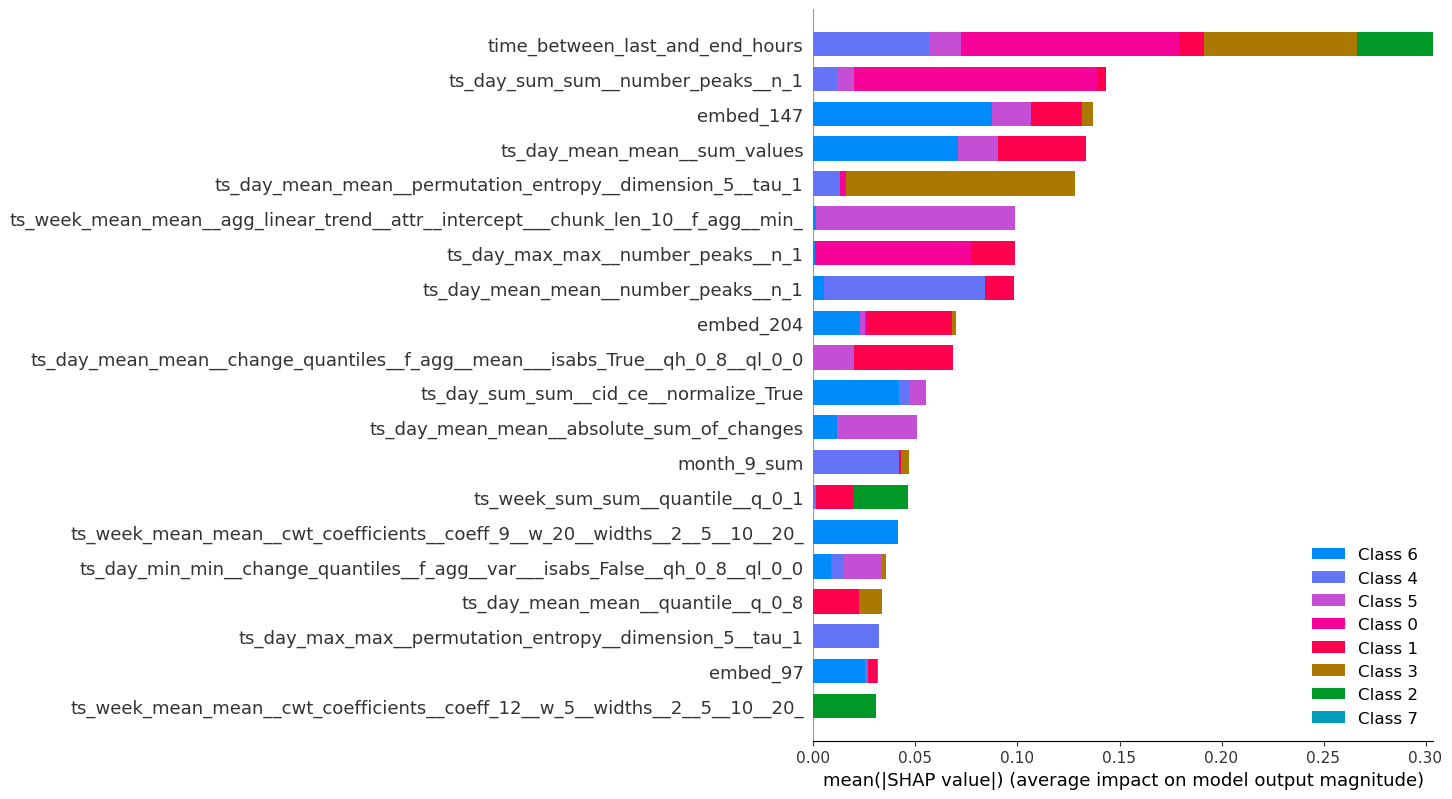

In [11]:
import shap

# Инициализируем explainer с вашей моделью
explainer = shap.TreeExplainer(model)

# Вычисляем SHAP значения для валидационного набора (можно использовать и тренировочный)
shap_values = explainer.shap_values(lgb_X_val)

# Визуализация важности признаков (среднее абсолютное значение SHAP)
shap.summary_plot(shap_values, lgb_X_val, plot_type="bar")

In [20]:
tr[['client_num', 'time_between_last_and_end_hours']].sort_values('client_num')

,client_num,time_between_last_and_end_hours
54429,1,6.083333
69304,2,4.400000
54543,3,2.066667
39100,4,3.433333
19645,5,65.616667
...,...,...
27657,109136,1280.816667
53872,109138,15.366667
29655,109139,1091.733333
67622,109141,677.900000
